In this notebook, we use a subset of the [Tox21 data challenge](https://tripod.nih.gov/tox21/challenge/about.jsp), specifically the androgen receptor subset, to demonstrate the use of morgan fingerprints in combination with machine learning to predict the activity of chemical compounds in a biochemical screening. 

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize

import requests
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

# Loading and preparing the dataset
The dataset contains SMILES string that encode the chemical structure of the screened compound and the information if this compound was active in the assay (target variable):

In [2]:
url = "https://tripod.nih.gov/tox21/challenge/download?id=nr-arsmiles&sec="
r = requests.get(url)
data = r.text.split("\n")
df = pd.DataFrame([x.split("\t") for x in data], columns=["smiles", "id", "active"])

df.head()

,smiles,id,active
0,CC(O)=O.CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N...,NCGC00167516-01,0
1,Cl.CCCCCCOC1=CC=C(C(=N)N(CCCC)CCCC)C2=C1C=CC=C2,NCGC00181091-01,0
2,Cl.Cl.COCC(=O)O[C@]3(CCN(C)CCCC1=NC2=C(N1)C=CC...,NCGC00094089-01,0
3,Cl.Cl.CCCCC(CC)CNC(=N)NC(=N)NCCCCCCNC(=N)NC(=N...,NCGC00094996-01,0
4,[Br-].CCCCCCCCCCCC[N+](C)(C)CCOC1=CC=CC=C1,NCGC00257773-01,0


We use RDKit to convert the SMILES strings into structures. However, some of the SMILES (e.g. below) cannot be converted to molecules by RDKit, so we will make sure to filter out the problematic structures:

In [3]:
df.smiles[2168]

'[NH4+].[NH4+].F[Si--](F)(F)(F)(F)F'

In [4]:
df["active"] = pd.to_numeric(df["active"] , errors="coerce", downcast="integer")
df["mol"] = np.nan

idx_to_drop = []
for idx, smile in enumerate(df.smiles):
    mol = Chem.MolFromSmiles(smile)
    if (mol is None) or (df.active[idx] not in [0, 1]):
        idx_to_drop.append(idx)
    else:
        df.loc[idx, ["mol"]] = mol
        
df = df.drop(index=idx_to_drop).reset_index(drop=True)

Additionally, some of the molecules contain counter ions and solvent molecules that we want to remove. Counter ions are removed by assuming that these are smaller than the parent compound of interest. Furthermore, charges of the parent compound are removed if possible:

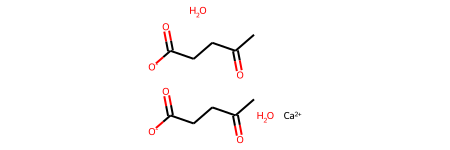

In [5]:
df.mol[2147]

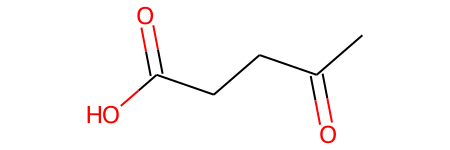

In [6]:
uncharger = rdMolStandardize.Uncharger()

for idx, smile in enumerate(df.smiles):
    df.loc[idx, ["smiles"]] = max(smile.split("."), key=len)
    df.loc[idx, ["mol"]] = uncharger.uncharge(Chem.MolFromSmiles(df["smiles"][idx]))

df.mol[2147]

# Creating  and training a model
We will create features from the molecules by using morgan fingerprints and train a LightGBM model on this data:

In [7]:
X1 = np.zeros((len(df), 1024), dtype=np.int8)

for count, mol in enumerate(df.mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    DataStructs.ConvertToNumpyArray(fp, X1[count, :])
    
X1

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [8]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, df["active"].to_numpy(), test_size=0.3, random_state=42)

In [9]:
pipe1 = Pipeline(steps=[("classifier", LGBMClassifier(importance_type="gain"))])
param_grid1 = {"classifier__learning_rate": [0.02, 0.05, 0.1, 0.15, 0.2],
               "classifier__max_depth": [4, 5, 6, 7]}
grid1 = GridSearchCV(estimator=pipe1, param_grid=param_grid1, cv=5, scoring="f1")
model1 = grid1.fit(X1_train, y_train)

print(f"Following hyperparameters were found to give best results: {model1.best_params_}")

Following hyperparameters were found to give best results: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5}


As we can see from the confusion matrix below, the dataset is highly imbalanced. There are siginificantly more inactive compounds in the dataset. There are several strategies to deal with class imbalance. This notebook is however not about class imbalance, so other than using the F1 score as a metric, we will ignore the problems associated with class imabalance:

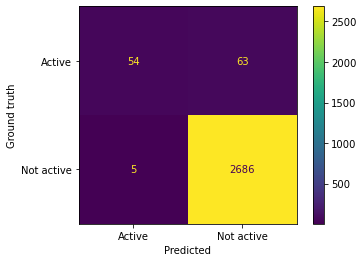

F1 score: 0.614


In [10]:
y_test_pred_m1 = model1.predict(X1_test)
cm = confusion_matrix(y_test, y_test_pred_m1, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["Active", "Not active"])
plt.yticks([0,1], ["Active", "Not active"])
plt.ylabel("Ground truth")
plt.xlabel("Predicted")
plt.show()

score_model1 = f1_score(y_test, y_test_pred_m1)

print(f"""F1 score: {score_model1:.3f}""")

# Counting the Occurences of  Morgan Fingerprints
Above, we used RDKits "GetMorganFingerprintAsBitVect" functionality to obtain morgan fingerprint. This functionality only records if a certain fingerprint is either there (1) or not there (0) but not how many times the fingerprint is there. Recording the number of times a fingerprint occurs might imrpove performance, so we will try this out:

In [11]:
X2 = np.zeros((len(df), 1024), dtype=np.int8)

for count, mol in enumerate(df.mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, radius=2, nBits=1024)
    DataStructs.ConvertToNumpyArray(fp, X2[count, :])
    
X2

array([[0, 8, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [12]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, df["active"].to_numpy(), test_size=0.3, random_state=42)

In [13]:
pipe2 = Pipeline(steps=[("classifier", LGBMClassifier(importance_type="gain"))])
param_grid2 = {"classifier__learning_rate": [0.05, 0.1, 0.15, 0.2, 0.3],
               "classifier__max_depth": [7, 8, 9, 10]}

grid2 = GridSearchCV(estimator=pipe2, param_grid=param_grid2, cv=5, scoring="f1")
model2 = grid2.fit(X2_train, y_train)

print(f"Following hyperparameters were found to give best results: {model2.best_params_}")

Following hyperparameters were found to give best results: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 9}


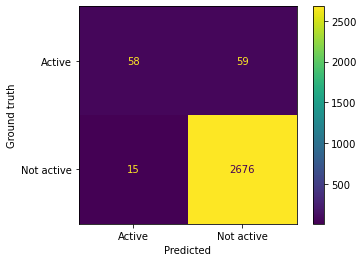

F1 score: 0.611


In [14]:
y_test_pred_m2 = model2.predict(X2_test)
cm = confusion_matrix(y_test, y_test_pred_m2, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["Active", "Not active"])
plt.yticks([0,1], ["Active", "Not active"])
plt.ylabel("Ground truth")
plt.xlabel("Predicted")
plt.show()

score_model2 = f1_score(y_test, y_test_pred_m2)

print(f"""F1 score: {score_model2:.3f}""")

Unfortunately, this did not improve the performance of our model.

# Interpreting the model
Other than predicting if a molecule is active or not, we might be interessted which fingerprints influence activity. Fortunately, the LightGBM gives us functionality to assess feature importance and RDKit provides functionality to convert the fingerprint bits into structures: 

In [15]:
f_importance_m2 = model2.best_estimator_.named_steps["classifier"].feature_importances_
f_importance_m2_sorted = np.sort(f_importance_m2)[::-1]
f_importance_m2_sorted_idxs = np.argsort(f_importance_m2)[::-1]

print(f"""The most important feature is feature {f_importance_m2_sorted_idxs[0]} with a feature \
importance of {f_importance_m2_sorted[0]:.2f}. The second most important feature is feature {f_importance_m2_sorted_idxs[1]} \
with a importance of {f_importance_m2_sorted[1]:.2f}.""")

The most important feature is feature 519 with a feature importance of 3727.76. The second most important feature is feature 84 with a importance of 937.51.


Let's look at the most important fingerprint:

In [16]:
important_f_bit = f_importance_m2_sorted_idxs[0]
important_f_bit_no_of_occurences_per_molecule = np.sort(X2[:, important_f_bit])[::-1]
important_f_bit_no_of_occurences_per_dataset = sum(important_f_bit_no_of_occurences_per_molecule != 0)
print(f"""This feature bit is found in {important_f_bit_no_of_occurences_per_dataset} of the molecules contained in \
this dataset.""")

important_f_bit_mol_idx = np.argsort(X2[:, important_f_bit])[::-1][0:important_f_bit_no_of_occurences_per_dataset]
print(f"""The first five molecules containing this feature bit have following indices: 
{important_f_bit_mol_idx[0:5]}...""")

This feature bit is found in 355 of the molecules contained in this dataset.
The first five molecules containing this feature bit have following indices: 
[ 891 2910  785 1134  722]...


And display the five first occurences of this fingerprint and wether the parent compound is active or not:

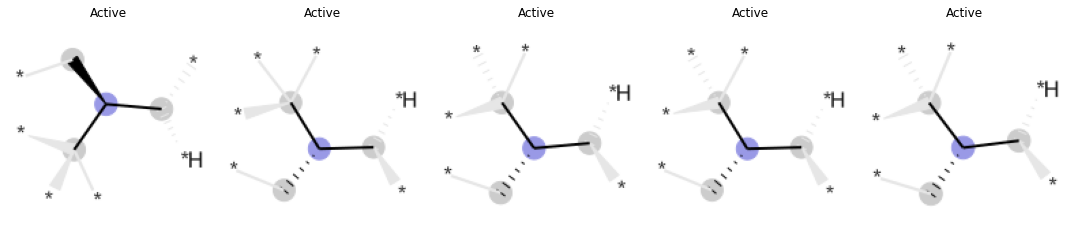

In [17]:
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for count, fp_idx in enumerate(important_f_bit_mol_idx[0:5]):
    mol = df.mol[fp_idx]
    bi = {}
    AllChem.GetHashedMorganFingerprint(mol, radius=2, nBits=1024, bitInfo=bi)
    image = Draw.DrawMorganBit(mol, important_f_bit, bi)
    ax[count].imshow(image)
    if df.active[fp_idx] == 1:
        ax[count].set_title("Active")
    else:
        ax[count].set_title("Inactive")
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
plt.show()

Pretty amazing. We identified a substructure that seems to have significant impact on activity. Let's look at the second most important feature:

In [18]:
important_f_bit = f_importance_m2_sorted_idxs[1]
important_f_bit_no_of_occurences_per_molecule = np.sort(X2[:, important_f_bit])[::-1]
important_f_bit_no_of_occurences_per_dataset = sum(important_f_bit_no_of_occurences_per_molecule != 0)
print(f"""This feature bit is found in {important_f_bit_no_of_occurences_per_dataset} of the molecules contained in \
this dataset.""")

important_f_bit_mol_idx = np.argsort(X2[:, important_f_bit])[::-1][0:important_f_bit_no_of_occurences_per_dataset]
print(f"""The first five molecules containing this feature bit have following indices:
{important_f_bit_mol_idx[0:5]}.""")

This feature bit is found in 296 of the molecules contained in this dataset.
The first five molecules containing this feature bit have following indices:
[ 682 5032  532  146  365].


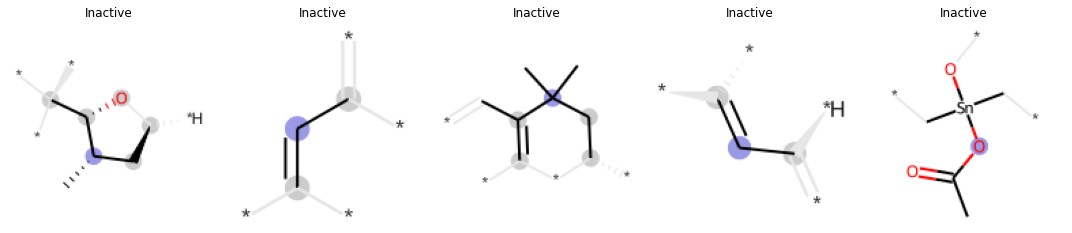

In [19]:
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for count, fp_idx in enumerate(important_f_bit_mol_idx[0:5]):
    mol = df.mol[fp_idx]
    bi = {}
    AllChem.GetHashedMorganFingerprint(mol, radius=2, nBits=1024, bitInfo=bi)
    image = Draw.DrawMorganBit(mol, important_f_bit, bi)
    ax[count].imshow(image)
    if df.active[fp_idx] == 1:
        ax[count].set_title("Active")
    else:
        ax[count].set_title("Inactive")
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
plt.show()

Wait a second. What happened here? Quite different substructures seem to be encoded into this feature bit...

# Bit collisions and morgan fingerprints

The issue is well known, see for example following publication:
- Rogers & Hahn [Extended-Connectivity Fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t). *J. Chem. Inf. Model.* **2010**, *50*, 5, 742–754.

Or the following posts on RDKit blog:
- http://rdkit.blogspot.com/2014/02/colliding-bits.html
- http://rdkit.blogspot.com/2014/03/colliding-bits-ii.html
- http://rdkit.blogspot.com/2016/02/colliding-bits-iii.html

RDKits "GetMorganFingerprintAsBitVect" and "GetHashedMorganFingerprint" functionality use a hash function that may caus hash/bit collisions, especially if the nbit parameter is set to a relatively small number. 

For its traditional use as a tool for similiarity search, these bit collisions are mostly not of great relevance. There is no canonical definition of molecular similiarity after all, the collision are not too frequent, but the reduction of computational overhead by the hashing scheme is significant.

For the use of morgan fingerprints in machine learning applications, these bit collisions are however relevant. They can hurt the performance of models and as seen above they can make model interpretation harder. The effect of bit collisions in morgan fingerprints for the use of machine learning has been studied in following publication:
- Kensert et al. [Evaluating parameters for ligand-based modeling with random forest on sparse data sets](https://jcheminf.biomedcentral.com/track/pdf/10.1186/s13321-018-0304-9.pdf). *J. Cheminformatics* **2018**, 10:49. 

So let's have a look how we can obtain morgan fingerprints without bit collisions and what effect this will have: 

In [20]:
list_of_fp = []
list_of_fp_keys = []
for count, mol in enumerate(df.mol):
    fp = AllChem.GetMorganFingerprint(mol, radius=2).GetNonzeroElements()
    list_of_fp.append(fp)
    list_of_fp_keys.extend([key for key in fp.keys() if key not in list_of_fp_keys])

In [21]:
X3 = np.zeros((len(df), len(list_of_fp_keys)), dtype=np.int8)

for row_idx, fp in enumerate(list_of_fp):
    for (key, value) in fp.items():
        X3[row_idx, list_of_fp_keys.index(key)] = value

X3

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

In [22]:
X3_train, X3_test, y_train, y_test = train_test_split(X3, df["active"].to_numpy(), test_size=0.3, random_state=42)

In [23]:
pipe3 = Pipeline(steps=[("classifier", LGBMClassifier(importance_type="gain"))])
param_grid3 = {"classifier__learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
               "classifier__max_depth": [3, 4, 5, 6,]}

grid3 = GridSearchCV(estimator=pipe3, param_grid=param_grid3, cv=5, scoring="f1")
model3 = grid3.fit(X3_train, y_train)

print(f"Following hyperparameters were found to give best results: {model3.best_params_}")

Following hyperparameters were found to give best results: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4}


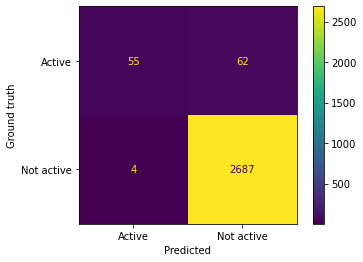

F1 score: 0.625


In [24]:
y_test_pred_m3 = model3.predict(X3_test)
cm = confusion_matrix(y_test, y_test_pred_m3, labels=[1,0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xticks([0,1], ["Active", "Not active"])
plt.yticks([0,1], ["Active", "Not active"])
plt.ylabel("Ground truth")
plt.xlabel("Predicted")
plt.show()

score_model3 = f1_score(y_test, y_test_pred_m3)

print(f"""F1 score: {score_model3:.3f}""")

In our case, it seems as if bit collisions did not have a major impact on model performance. So let's have a look if at least model interpretability is improved by looking at the second most important fingerprint just as above:

In [25]:
f_importance_m3 = model3.best_estimator_.named_steps["classifier"].feature_importances_
f_importance_m3_sorted = np.sort(f_importance_m3)[::-1]
f_importance_m3_sorted_idxs = np.argsort(f_importance_m3)[::-1]

print(f"""The most important feature is feature {f_importance_m3_sorted_idxs[0]} with a feature \
importance of {f_importance_m3_sorted[0]:.2f}. The second most important feature is feature {f_importance_m3_sorted_idxs[1]} \
with a importance of {f_importance_m3_sorted[1]:.2f}.""")

The most important feature is feature 341 with a feature importance of 2492.52. The second most important feature is feature 1984 with a importance of 510.45.


In [26]:
important_f_bit = f_importance_m3_sorted_idxs[1]
important_f_bit_no_of_occurences_per_molecule = np.sort(X3[:, important_f_bit])[::-1]
important_f_bit_no_of_occurences_per_dataset = sum(important_f_bit_no_of_occurences_per_molecule != 0)
print(f"""This feature bit is found in {important_f_bit_no_of_occurences_per_dataset} of the molecules contained in \
this dataset.""")

important_f_bit_mol_idx = np.argsort(X3[:, important_f_bit])[::-1][0:important_f_bit_no_of_occurences_per_dataset]
print(f"""The first five molecules containing this feature bit have following indices: 
{important_f_bit_mol_idx[0:5]}...""")

This feature bit is found in 214 of the molecules contained in this dataset.
The first five molecules containing this feature bit have following indices: 
[ 624  833  907 3727 3290]...


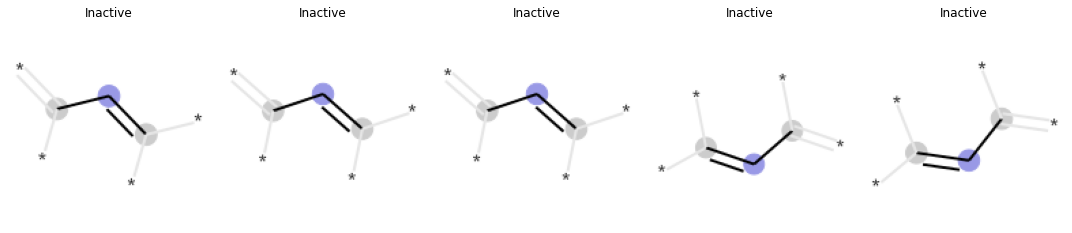

In [27]:
fig, ax = plt.subplots(1, 5, figsize=(15,10))
for count, fp_idx in enumerate(important_f_bit_mol_idx[0:5]):
    mol = df.mol[fp_idx]
    bi = {}
    AllChem.GetMorganFingerprint(mol, radius=2, bitInfo=bi)
    image = Draw.DrawMorganBit(mol, list_of_fp_keys[important_f_bit], bi)
    ax[count].imshow(image)
    if df.active[fp_idx] == 1:
        ax[count].set_title("Active")
    else:
        ax[count].set_title("Inactive")
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
plt.show()

This looks better than before. No more bit collisions!